# Estimating Oreintation Given STA

* Use GQM
* klist shoudl be a list of the GQM filters
* Make big data on CPU and then make GenericData on GPU and overwrite robs

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils import RFutils
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3_sca=3.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))

LGN cells: 214
V1 cells: 1491


In [4]:
V1_cell_key = [cell_key[i] for i in V1_idx]
L23_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L2/3']
L23_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L2/3']
L4_exc_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(V1_cell_key) if val == 'V1_Inh_L4']

In [5]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=V1_idx)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 17.64830708503723 sec


In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 12
L = 60


In [7]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 1491


In [8]:
NT = data.NT
print('Number of time points', NT)

Number of time points 170000


In [9]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[V1_idx], y_pos[V1_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (1491, 2)


## GLM

In [10]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

In [11]:
glms = []
for i in range(NC):
    j = V1_idx[i]
    cell_data = SimCloudData(file_name=out_file, down_sample=2, cell_idx=[j])
    glm_i = NDN( layer_list=[glm_par], loss_type='poisson')
    fit_lbfgs(glm_i, cell_data[:], verbose=False, device=device)
    glms.append(glm_i)
    print("GLM computed for cell",i)

KeyboardInterrupt: 

In [26]:
ex = glms[0].get_weights()[:,:,:,0]
ex.shape

(60, 60, 12)

## GQM

In [18]:
Treg = 1
XregL, XregQ = 10000.0, 10.0
LOCregL, LOCregQ = 10.0, 1000.0
L1regL, L1regQ = 1.0, None

# linear layer
glm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=1, bias=False, norm_type=0, 
    NLtype='lin', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregL, 'd2t': Treg, 'l1': L1regL, 'glocalx': LOCregL,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# quadratic layer
gqm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=2, bias=False, norm_type=0, 
    NLtype='square', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregQ, 'd2t': Treg, 'l1': L1regQ, 'glocalx': LOCregQ,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# set up linear and quadratic network
lin_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [glm_layer] )
quad_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [gqm_layer] )

# NDN layer that combines quadratic and linear layer
comb_layer = NDNLayer.layer_dict( num_filters=1, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

# set up combination network
comb_net = FFnetwork.ffnet_dict( xstim_n=None, ffnet_n=[0,1], layer_list=[comb_layer],)

# put together all networks
gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')

# don't fit weights in last layer
gqm.set_parameters(val=False,name='weight',ffnet_target=2)

gqm.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([43200, 1])
Network 1:
  Layer 0:
      weight: torch.Size([43200, 2])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([3, 1])
      bias: torch.Size([1])


In [67]:
gqms = []
for ii in range(5):
    i = L23_inh_idx[ii]
    gdata = GenericDataset( {'stim': data[data.train_blks]['stim'], 
                         'robs': data[data.train_blks]['robs'][:,i], 
                         'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)

    
    gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata[:], verbose=False)
    gqm = gqm.to(device0)
    gqms.append(gqm)
    print('Cell', i, 'GQM complete')

    gdata = None

Cell 1329 GQM complete
Cell 1330 GQM complete
Cell 1331 GQM complete
Cell 1332 GQM complete
Cell 1333 GQM complete


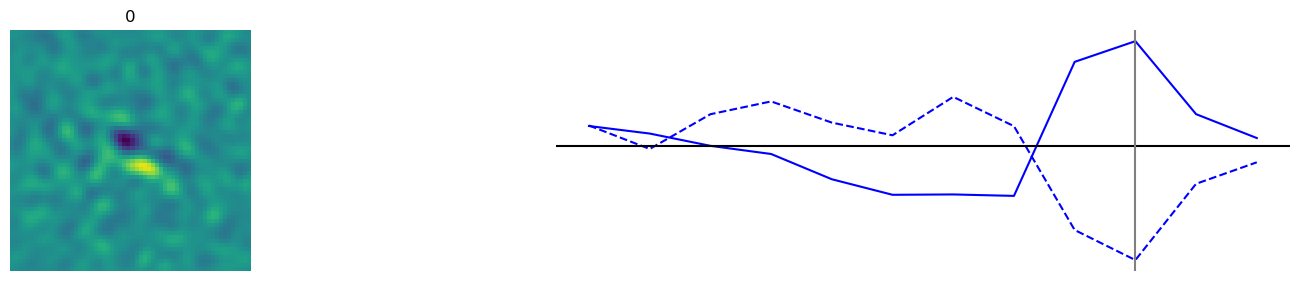

In [51]:
jj = 0
gqms[jj].plot_filters(ffnet_target=0)

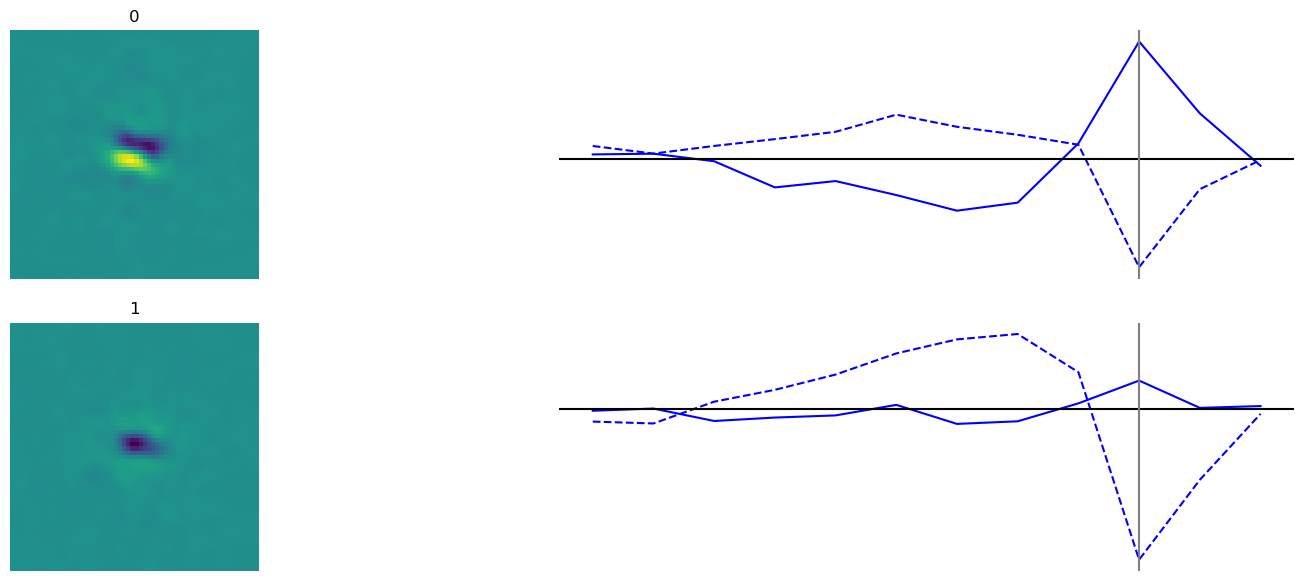

In [52]:
gqms[jj].plot_filters(ffnet_target=1)

## Orientation

In [68]:
thetas = np.zeros(NC)
osis = np.zeros(NC)
for cc in range(5):
    thetas[cc], osis[cc] = RFutils.filter_orientation_stats( gqm=gqms[cc], to_plot=False)

In [69]:
thetas

array([ 30.,  24., 108., ...,   0.,   0.,   0.])

In [70]:
osis

array([0.28657788, 0.42958998, 0.31730268, ..., 0.        , 0.        ,
       0.        ])

In [22]:
print(thetas.shape)
print(osis.shape)

(1491,)
(1491,)


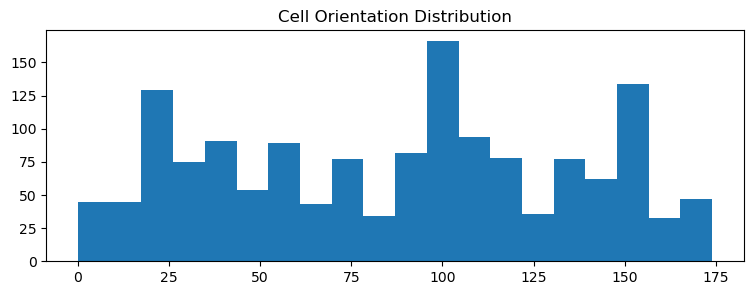

In [25]:
plt.figure(figsize=(9,3))
plt.hist(thetas ,bins=20)
plt.title('Cell Orientation Distribution')
plt.show()

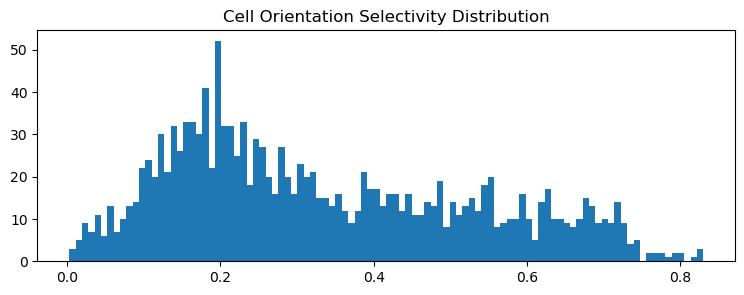

In [24]:
plt.figure(figsize=(9,3))
plt.hist(osis ,bins=100)
plt.title('Cell Orientation Selectivity Distribution')
plt.show()

In [26]:
print("Layer 4 exc avg osi:", np.mean(osis[L4_exc_idx]))
print("Layer 4 inh avg osi:", np.mean(osis[L4_inh_idx]))
print("Layer 2/3 exc avg osi:", np.mean(osis[L23_exc_idx]))
print("Layer 2/3 exc avg osi:", np.mean(osis[L23_inh_idx]))

Layer 4 exc avg osi: 0.4469816435626491
Layer 4 inh avg osi: 0.4538216674924096
Layer 2/3 exc avg osi: 0.20002979770637405
Layer 2/3 exc avg osi: 0.20989529671431228


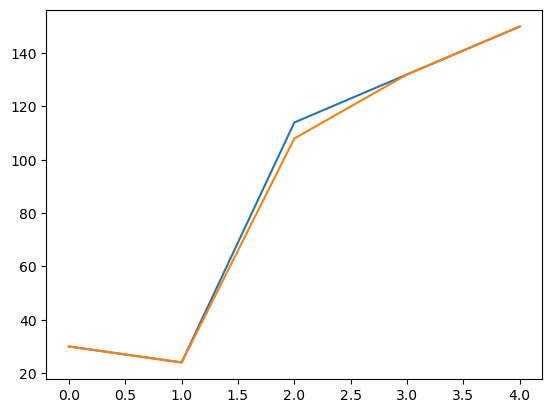

In [71]:
plt.plot(thetas1[L23_inh_idx[:5]])
plt.plot(thetas[:5])

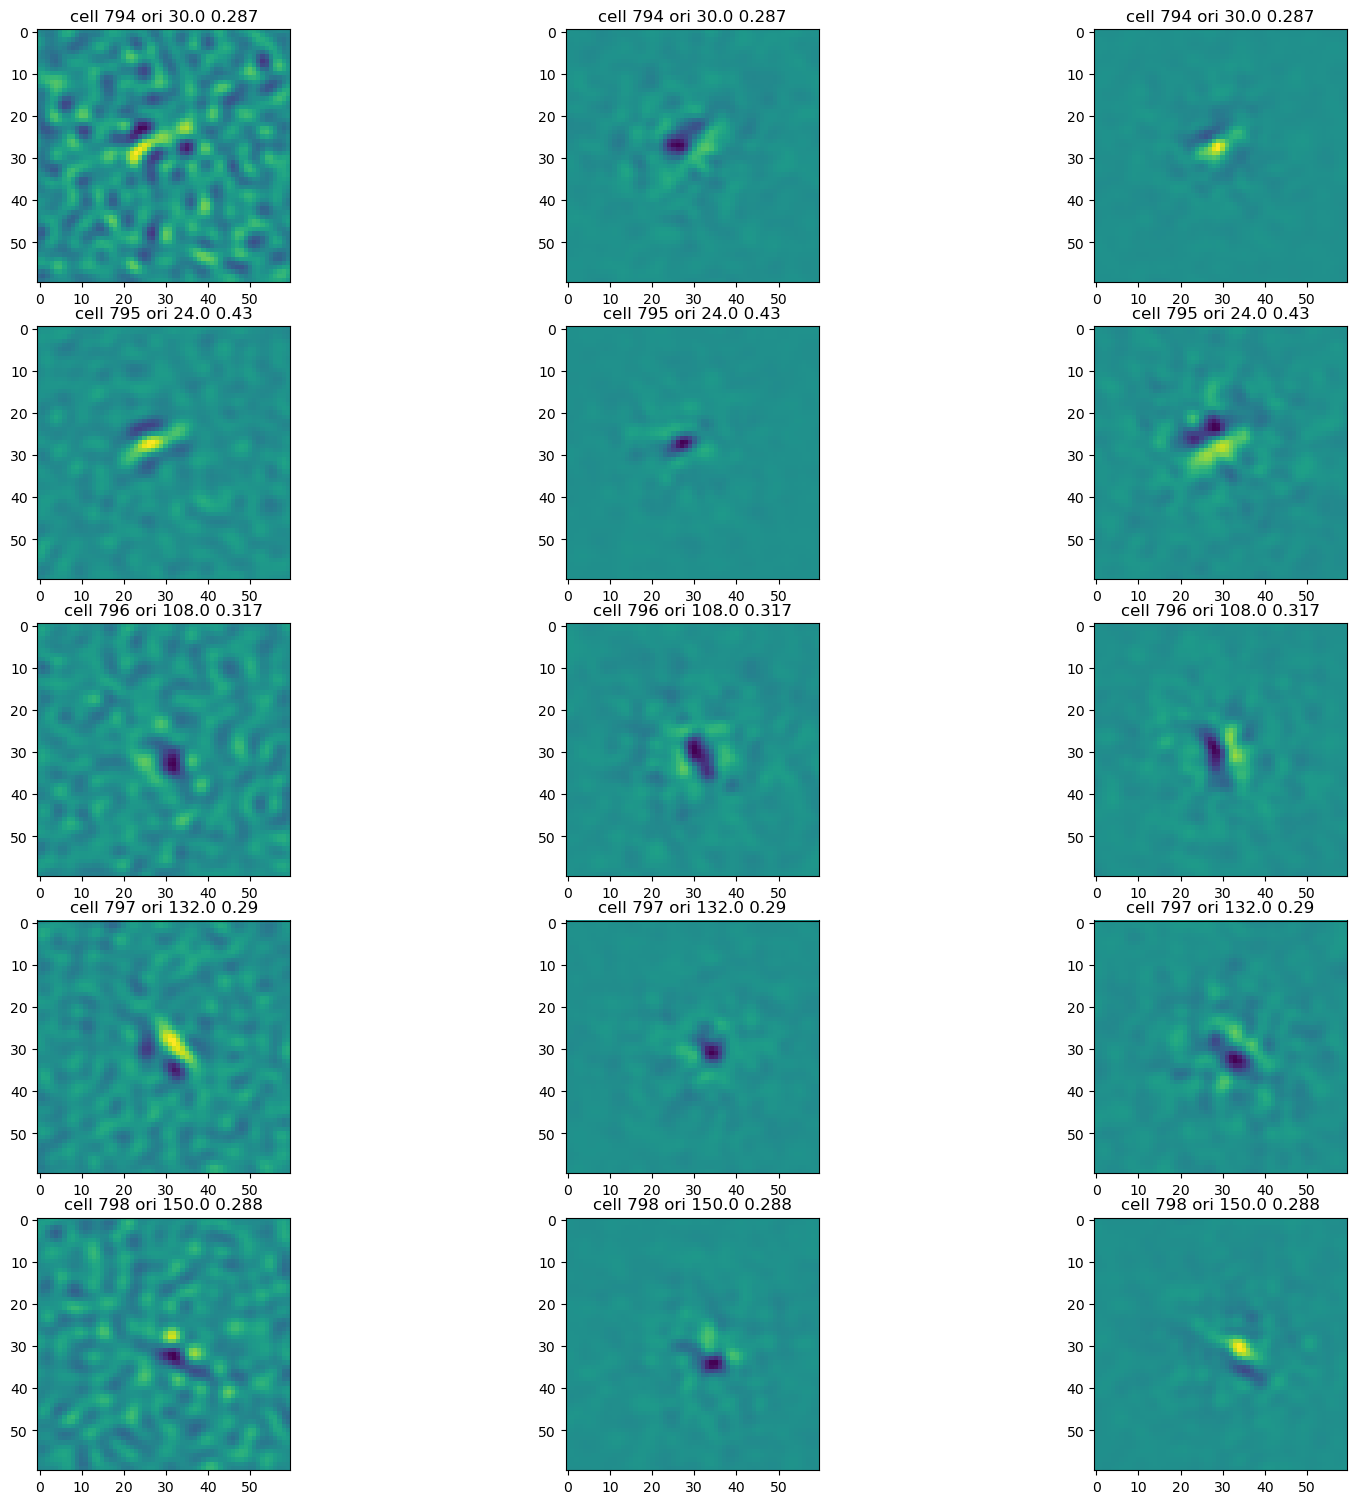

In [72]:
ss(5,3)
k = 1
for i in range(5):
    l = L23_exc_idx[i]

    plt.subplot(5,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=0)[:,:,5,0])
    plt.title('cell '+str(l)+' ori '+str(thetas[i])+' '+str(np.round(osis[i],3)))
    k += 1

    plt.subplot(5,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=1)[:,:,5,0])
    plt.title('cell '+str(l)+' ori '+str(thetas[i])+' '+str(np.round(osis[i],3)))
    k += 1

    plt.subplot(5,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=1)[:,:,5,1])
    plt.title('cell '+str(l)+' ori '+str(thetas[i])+' '+str(np.round(osis[i],3)))
    k += 1

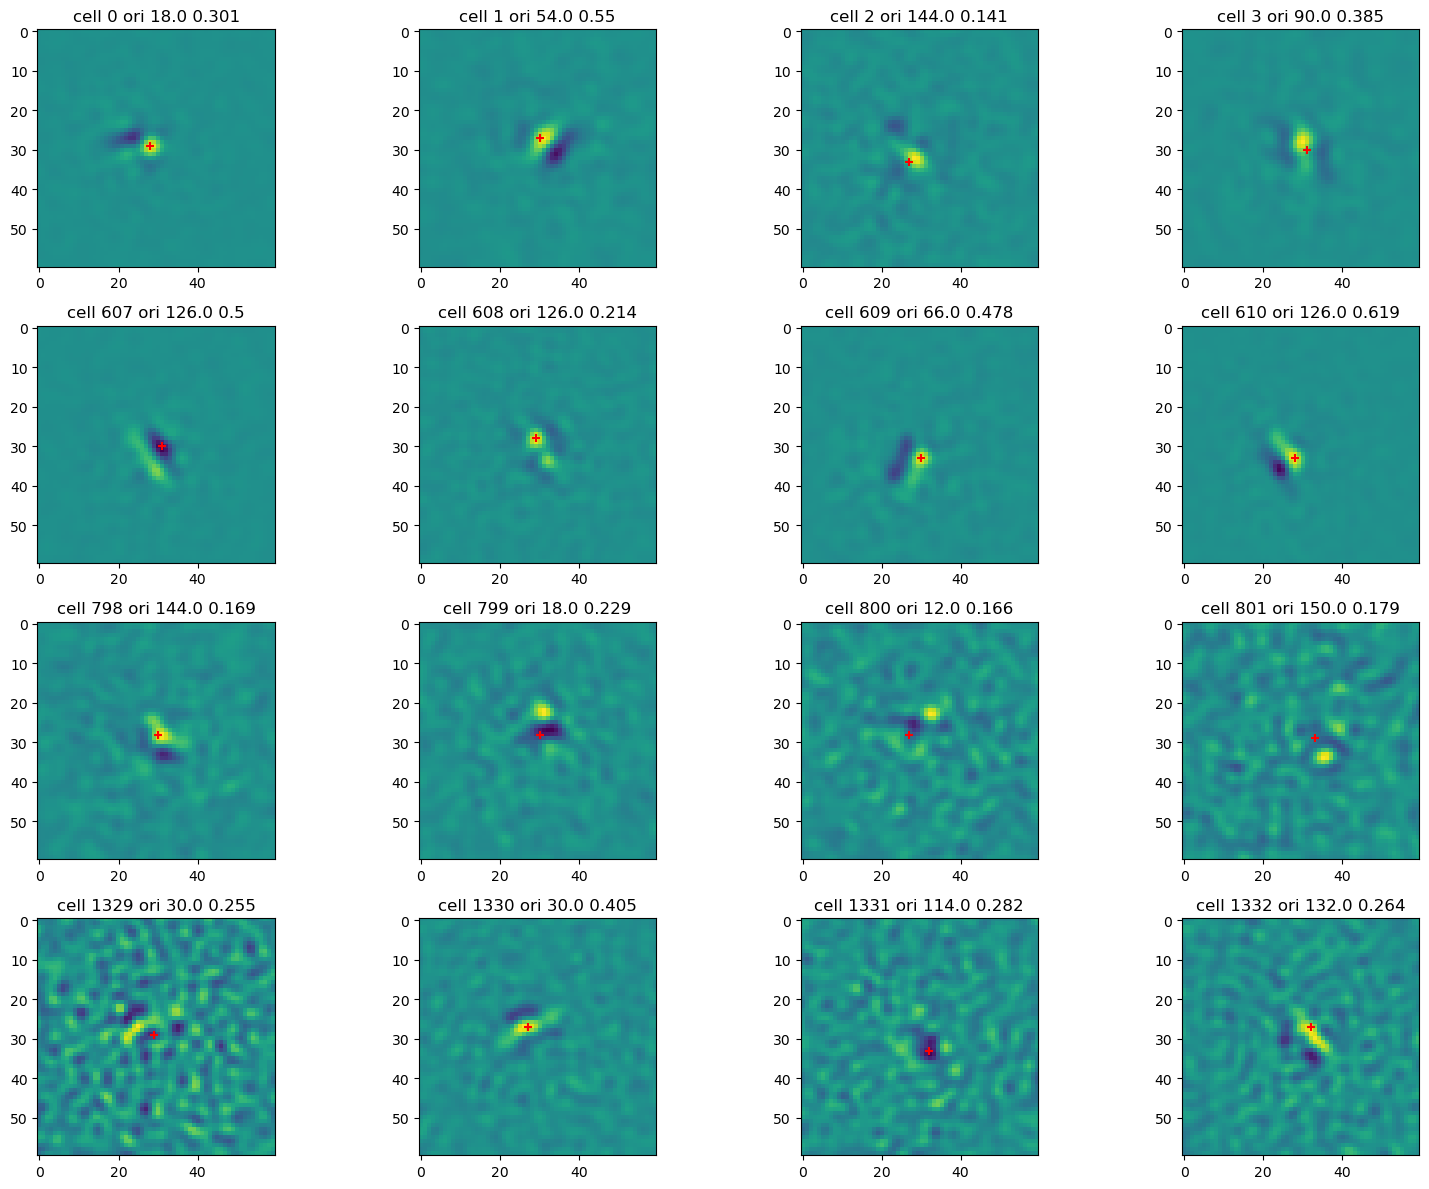

In [29]:
ss(4,4)
k = 1

for i in range(4):
    plt.subplot(4,4,k)
    l = L4_exc_idx[i]
    imagesc(gqms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L4_inh_idx[i]
    imagesc(gqms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L23_exc_idx[i+4]
    imagesc(gqms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1
for i in range(4):
    plt.subplot(4,4,k)
    l = L23_inh_idx[i]
    imagesc(gqms[l].get_weights()[:,:,5,0])
    plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
    plt.title('cell '+str(l)+' ori '+str(thetas[l])+' '+str(np.round(osis[l],3)))
    k += 1

plt.tight_layout()
plt.show()

## Save Orientation

In [30]:
cell_type_list = ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
ori_dict = {'thetas': {'V1_Exc_L4': thetas[L4_exc_idx], 'V1_Inh_L4': thetas[L4_inh_idx], 'V1_Exc_L2/3': thetas[L23_exc_idx], 'V1_Inh_L2/3': thetas[L23_inh_idx]},
            'osis': {'V1_Exc_L4': osis[L4_exc_idx], 'V1_Inh_L4': osis[L4_inh_idx], 'V1_Exc_L2/3': osis[L23_exc_idx], 'V1_Inh_L2/3': osis[L23_inh_idx]}}

In [31]:
import pickle
with open('data/V1_neuron_orientation_in_deg_and_orientation_selection_sqrad_0.3_GQM.pkl', 'wb') as f:
    pickle.dump(ori_dict, f)

## Comparing Orientations

In [12]:
# Load Orientation info from GLM
ori_dict1 = np.load('data/V1_neuron_orientation_in_deg_and_orientation_selection_sqrad_0.3.pkl', allow_pickle=True)
thetas1 = np.concatenate((ori_dict1['thetas']['V1_Exc_L4'], ori_dict1['thetas']['V1_Inh_L4'],ori_dict1['thetas']['V1_Exc_L2/3'], ori_dict1['thetas']['V1_Inh_L2/3']))
osis1 = np.concatenate((ori_dict1['osis']['V1_Exc_L4'], ori_dict1['osis']['V1_Inh_L4'],ori_dict1['osis']['V1_Exc_L2/3'], ori_dict1['osis']['V1_Inh_L2/3']))
print(thetas1.shape)
print(osis1.shape)

(1491,)
(1491,)


In [13]:
# Load Orientation info from GQM
ori_dict2 = np.load('data/V1_neuron_orientation_in_deg_and_orientation_selection_sqrad_0.3_GQM.pkl', allow_pickle=True)
thetas2 = np.concatenate((ori_dict2['thetas']['V1_Exc_L4'], ori_dict2['thetas']['V1_Inh_L4'],ori_dict2['thetas']['V1_Exc_L2/3'], ori_dict2['thetas']['V1_Inh_L2/3']))
osis2 = np.concatenate((ori_dict2['osis']['V1_Exc_L4'], ori_dict2['osis']['V1_Inh_L4'],ori_dict2['osis']['V1_Exc_L2/3'], ori_dict2['osis']['V1_Inh_L2/3']))
print(thetas2.shape)
print(osis2.shape)

(1491,)
(1491,)


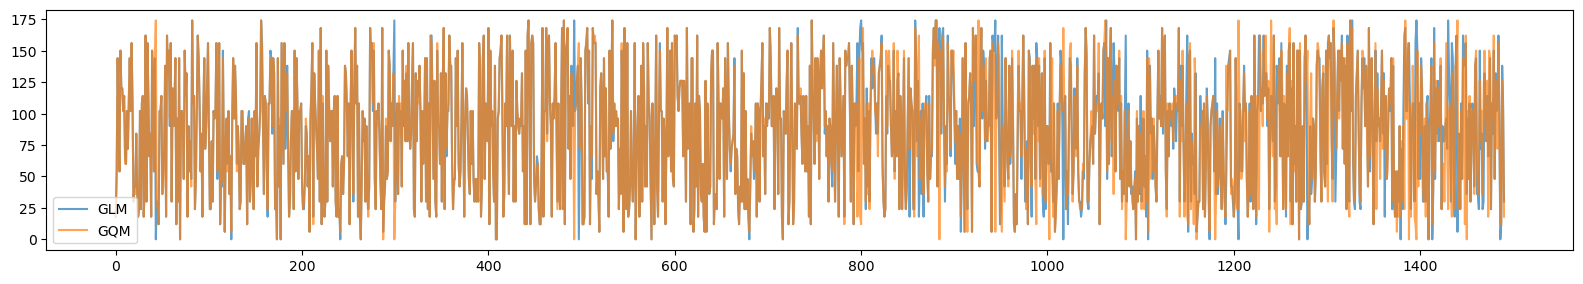

In [15]:
ss()
plt.plot(thetas1, label='GLM', alpha=0.7)
plt.plot(thetas2, label='GQM', alpha=0.7)
plt.legend()

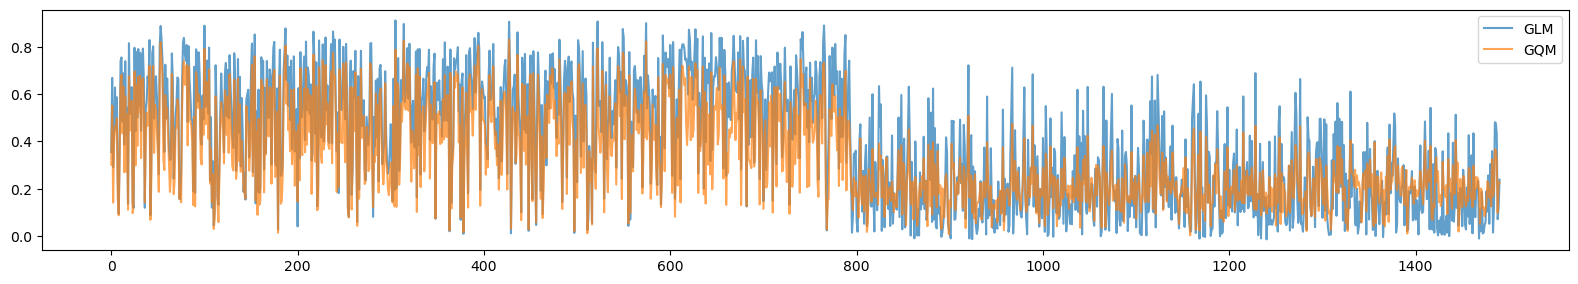

In [16]:
ss()
plt.plot(osis1, label='GLM', alpha=0.7)
plt.plot(osis2, label='GQM', alpha=0.7)
plt.legend()